# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
Проанализируйте скорость работы и качество моделей.

Примечания:
Для оценки качества моделей применяйте метрику RMSE.

Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
del features_train 



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span></span></li></ul></div>

# Описание данных

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Знакомство с данными

In [169]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [170]:
autos_df = pd.read_csv('/datasets/autos.csv')

In [171]:
def explore_data(df):
    display(
        "Сводная информация:", df.info(),
        "10 строк:", df.head(10),
        "Столбцы:", df.columns,
        "Числовое описание:", df.describe(),
        "Сумма пропусков:", df.isna().sum(),
        "Доля пропусков:", df.isna().mean(),
        "Явные дубликаты:", df.duplicated().sum(),
        "Корреляция:", df.corr(),
        sns.heatmap(df.corr())
    )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

'Сводная информация:'

None

'10 строк:'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


'Столбцы:'

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

'Числовое описание:'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Сумма пропусков:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Доля пропусков:'

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

'Явные дубликаты:'

4

'Корреляция:'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


<AxesSubplot:>

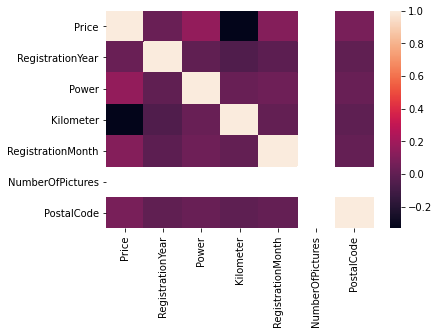

In [172]:
explore_data(autos_df)

### Вывод

* колонки VehicleType, Gearbox, Model, FuelType, NotRepaired, Brand можно попробовать заполнить как unknown
* FuelType — тип топлива, проверить уникальные значения, чем отличается petrol от gasoline -- одно и тоже
* RegistrationYear надо отфильтровать данные по годам 
* Power отсечь выбросы 
* Kilometer странно что медиана совпадает с max, проверить, отсечь выбросы
* RegistrationMonth >= 1, 0 быть не должно
* NumberOfPictures везде 0. Отставим без изменений. 
* колонки DateCrawled,DateCreated,LastSeen можно перевести в тип данных date, для анализа,но при обучении модели не будут использованы 
* Выявлено 4 явных дубликата
* сильных корреляция не выявлено

## Подготовка данных

Скорректируем названия столбцов в питонячем стиле)))

In [173]:
autos_df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

Выделим категории данных: числовые, категориальные и даты

In [174]:
numeric = ['price', 'registration_year', 'power', 'kilometer', 'registration_month',
        'number_of_pictures', 'postal_code']
categorial = ['vehicle_type','gearbox','not_repaired', 'model', 'fuel_type', 'brand']
dates = ['date_crawled', 'date_created', 'last_seen']

In [175]:
autos_df[['date_crawled','date_created','last_seen']] = autos_df[dates].apply(pd.to_datetime)


Определим последнюю дату скачивания анкеты из БД, чтобы отфильтровать даныые по году регистрации автомобиля

In [176]:
autos_df['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

In [177]:
autos_df.registration_year.max()

9999

Год регистрации автомобиляотсечем не может превышать 2016

<AxesSubplot:title={'center':'распределение по году регистрации'}, ylabel='Frequency'>

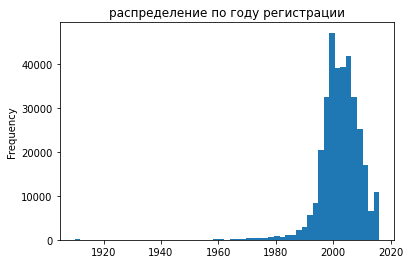

In [178]:
autos_df[(1900<=autos_df['registration_year']) & (autos_df['registration_year']<=2016)]['registration_year'].plot(kind='hist',bins=55,title='распределение по году регистрации')

Основная часть данных располагается в интервале 1990-2016, отфильтровываем

<AxesSubplot:title={'center':'распределение отфильтрованных данных по году регистрации автомобиля'}, ylabel='Frequency'>

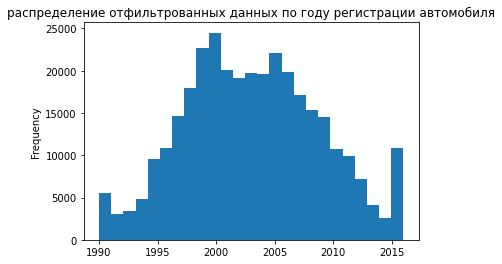

In [179]:
filtered_autos = autos_df[(1990<=autos_df['registration_year']) & (autos_df['registration_year']<=2016)]
filtered_autos.registration_year.plot(kind='hist',bins=25, title='распределение отфильтрованных данных по году регистрации автомобиля')

Пробег автомобилей ограничен значением 150к, все что ниже 90к считается выбросом, Возможно это более новые автомобили, вполне логично, что их продают реже

<AxesSubplot:xlabel='kilometer'>

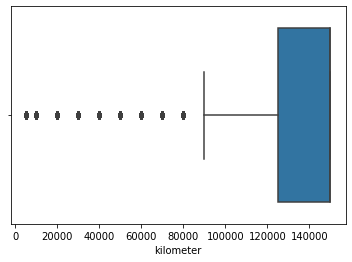

In [180]:
#sns.kdeplot(filtered_autos.kilometer)
#filtered_autos.kilometer.value_counts().sort_values().plot(kind='bar')
sns.boxplot(x=filtered_autos.kilometer)

### Заполнение пропусков

Необходимо заполнить пропуски в категориальных данных

In [181]:
filtered_autos[categorial].isna().mean()

vehicle_type    0.066366
gearbox         0.049880
not_repaired    0.187058
model           0.048560
fuel_type       0.077575
brand           0.000000
dtype: float64

В категориальных значениях заменим пропуски на 'unknown', думаю, другой способ только ухудшит качество

In [182]:
filtered_autos[categorial] = filtered_autos[categorial].fillna('unknown')

'gasoline' и 'petrol' есть одно и тоже, заменим значения на одинаковое

In [183]:
filtered_autos.fuel_type = filtered_autos.fuel_type.replace('gasoline', 'petrol')

Месяц регистрации не может быть меньше 1. Все нулевые значения равномерно распределим по другим месяцам

In [184]:
idx = filtered_autos.query('registration_month == 0').index
size = len(idx)//12
delta = len(idx) - size*12
print(len(idx), size,delta)

31655 2637 11


In [185]:
filtered_autos.registration_month.value_counts()

3     32304
0     31655
6     29578
4     27421
5     27400
7     25320
10    24802
12    22990
11    22972
9     22582
1     21694
8     21387
2     20065
Name: registration_month, dtype: int64

In [186]:

for i in range(1,13):
    if i <= delta:
        rand_choice = np.random.choice(idx, size=size+1,replace=False)
    else:
         rand_choice = np.random.choice(idx, size=size,replace=False)
    filtered_autos.loc[rand_choice,'registration_month'] = i
    #display(i,filtered_autos.loc[rand_choice,'registration_month'],size)
    idx = idx[~np.isin(idx, rand_choice)]
  

In [187]:
filtered_autos.registration_month.value_counts()

3     34942
6     32216
4     30059
5     30038
7     27958
10    27440
12    25627
11    25610
9     25220
1     24332
8     24025
2     22703
Name: registration_month, dtype: int64

Нулевые значения пропали. Теперь можно оценить распределеня в данных по категориям

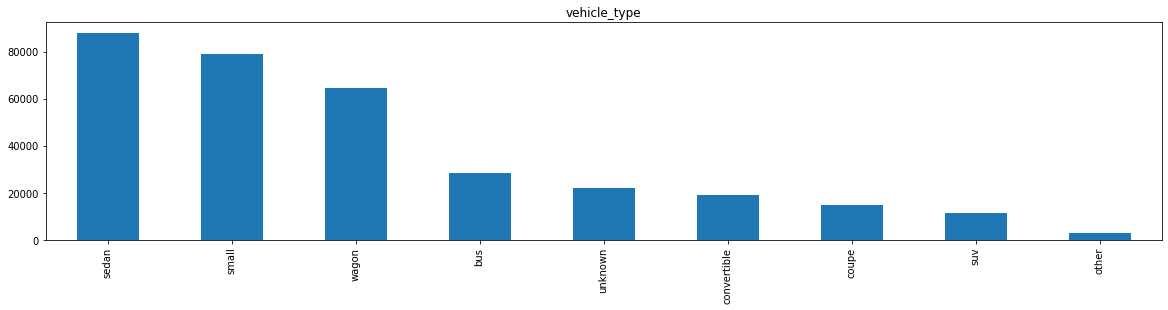

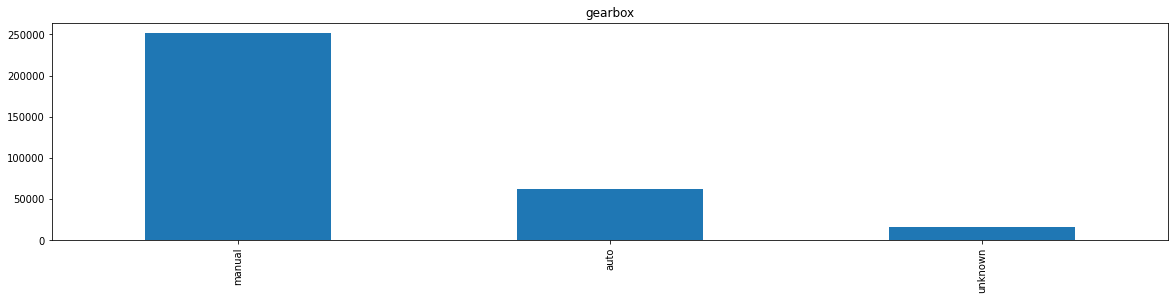

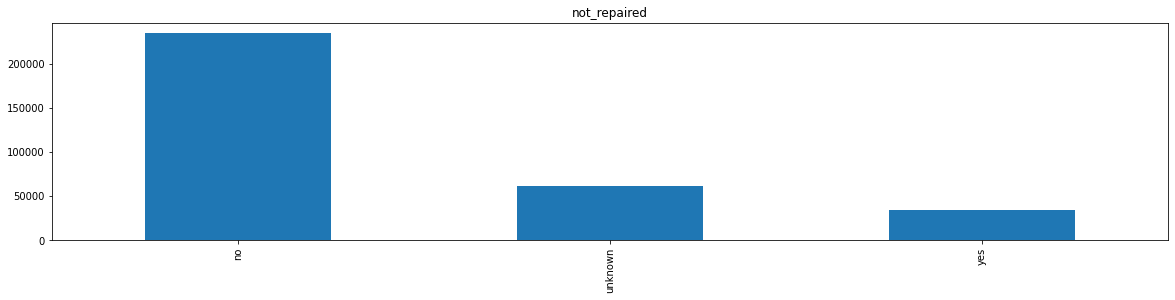

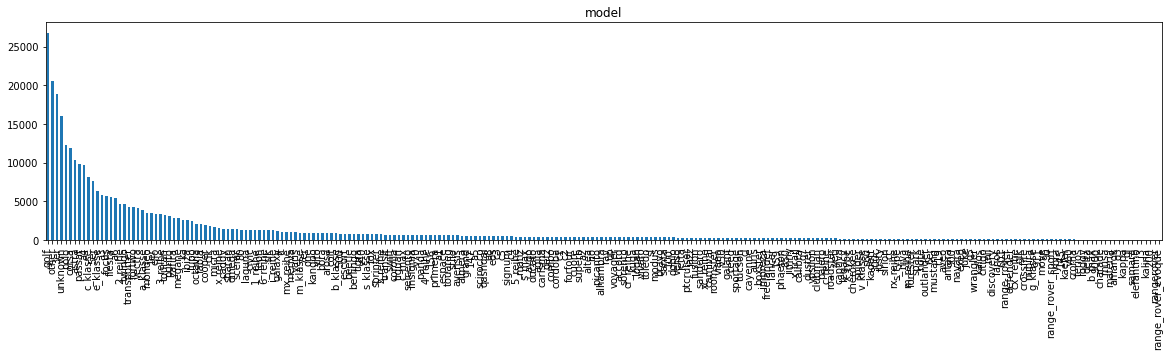

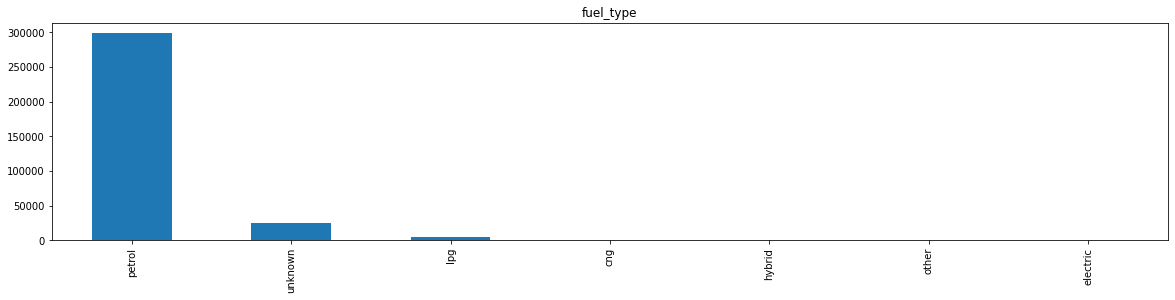

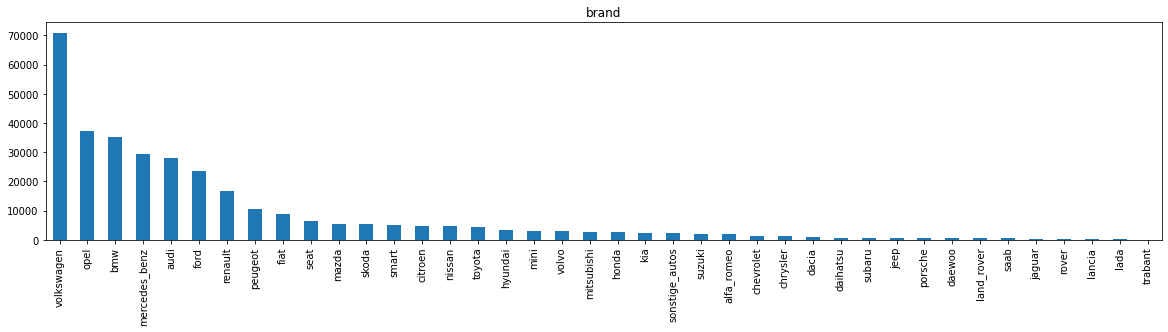

In [188]:
for column in categorial:
    filtered_autos[column].value_counts().plot(kind='bar', title=''+column, figsize=(20,4))
    plt.show()

В моделях получилось достаточно большое количество занчений `unknown`((( sad. `gearbox` и `no_repaired` можно закодировать с помощью OHE- количество категорий 3, сильно не повлияет на размерность. Для кодировки остальных можно воспользоваться labelencoder

### Очистка от выбросов дубликатов

Создадим функции, чтобы очистить данные от выбросов

In [189]:
# вычисляем Q1-IQR*1.5 и Q3+IQR*1.5 для каждого столбца
def count_moustache(descr):
    res = {}
    for column in descr.columns:
        iqr = descr[column]['75%'] - descr[column]['25%']
        floor_outlier_tail = descr[column]['25%'] - (iqr) * 1.5
        ceiling_outlier_tail = descr[column]['75%'] + (iqr) * 1.5
        if floor_outlier_tail < 0: # ни одна из выбранных характеристик набора не может быть < 0
            floor_outlier_tail = 0 # поэтому Q1-IQR*1.5 установим в 0
        res[column] = (floor_outlier_tail, ceiling_outlier_tail)
    return res

# отфильтровываем выбросы
def filter_data(columns,moustache, data):
    filtered_data = data.copy()
    for column in columns:
        filtered_data = filtered_data[(filtered_data[column] > moustache[column][0]) &
                                      (filtered_data[column] < moustache[column][1])]
    #display(filtered_data)
    return  filtered_data 

In [190]:
def clean_data(eda_columns, data=autos_df):
    describe = data[eda_columns].describe()
    #display(data[eda_columns].corr())
    #display(sns.heatmap(data[eda_columns].corr()))
    moustache = count_moustache(describe) # усы для ящика каждого столбца
    print("усы: ",moustache)
    filtered_data = filter_data(eda_columns, moustache, data)
    display(filtered_data.shape, data.shape) # не испортил ли исходный набор
    #plot_hists(eda_columns, filtered_data)
    display("Описание отфильтрованного набора", filtered_data[eda_columns].describe())
    return filtered_data



In [191]:
outlier_filtered_autos = clean_data(['kilometer', 'price', 'power'], filtered_autos)    

усы:  {'kilometer': (87500.0, 187500.0), 'price': (0, 14601.5), 'power': (0, 251.0)}


(233706, 16)

(330170, 16)

'Описание отфильтрованного набора'

,kilometer,price,power
count,233706.000000,233706.000000,233706.000000
mean,142250.969166,3615.828635,116.229344
std,16516.579878,3263.847569,44.763605
min,90000.000000,1.000000,1.000000
25%,150000.000000,1150.000000,75.000000
50%,150000.000000,2500.000000,110.000000
75%,150000.000000,5100.000000,143.000000
max,150000.000000,14600.000000,250.000000


In [192]:
outlier_filtered_autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Пропусков в "чистом" наборе нет, проверим на наличи дубликатов и удалим

In [193]:
outlier_filtered_autos.duplicated().sum()

3

In [194]:
outlier_filtered_autos = outlier_filtered_autos.drop_duplicates().reset_index(drop=True)

In [195]:
outlier_filtered_autos.duplicated().sum()

0

### Кодирование категорий

`gearbox` и `no_repaired` можно закодировать с помощью OHE- количество категорий 3, сильно не повлияет на размерность. Для кодировки остальных можно воспользоваться labelencoder

In [196]:
print(outlier_filtered_autos.shape)
outlier_filtered_autos = pd.get_dummies(outlier_filtered_autos, columns=['gearbox','not_repaired'], drop_first=True)
print(outlier_filtered_autos.shape)

(233703, 16)
(233703, 18)


In [197]:

encoder = OrdinalEncoder()
outlier_filtered_autos[['vehicle_type', 'model', 'fuel_type', 'brand']] = encoder.fit_transform(outlier_filtered_autos[['vehicle_type', 'model', 'fuel_type', 'brand']])

In [198]:
outlier_filtered_autos.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_crawled          5 non-null      datetime64[ns]
 1   price                 5 non-null      int64         
 2   vehicle_type          5 non-null      float64       
 3   registration_year     5 non-null      int64         
 4   power                 5 non-null      int64         
 5   model                 5 non-null      float64       
 6   kilometer             5 non-null      int64         
 7   registration_month    5 non-null      int64         
 8   fuel_type             5 non-null      float64       
 9   brand                 5 non-null      float64       
 10  date_created          5 non-null      datetime64[ns]
 11  number_of_pictures    5 non-null      int64         
 12  postal_code           5 non-null      int64         
 13  last_seen             5 

### разделение набора

In [199]:
features = outlier_filtered_autos.drop(dates+['price'], axis=1)
target = outlier_filtered_autos['price']

In [200]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233703 entries, 0 to 233702
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vehicle_type          233703 non-null  float64
 1   registration_year     233703 non-null  int64  
 2   power                 233703 non-null  int64  
 3   model                 233703 non-null  float64
 4   kilometer             233703 non-null  int64  
 5   registration_month    233703 non-null  int64  
 6   fuel_type             233703 non-null  float64
 7   brand                 233703 non-null  float64
 8   number_of_pictures    233703 non-null  int64  
 9   postal_code           233703 non-null  int64  
 10  gearbox_manual        233703 non-null  uint8  
 11  gearbox_unknown       233703 non-null  uint8  
 12  not_repaired_unknown  233703 non-null  uint8  
 13  not_repaired_yes      233703 non-null  uint8  
dtypes: float64(4), int64(6), uint8(4)
memory usage: 18.7

In [201]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [202]:
features_train.head()

,vehicle_type,registration_year,power,model,kilometer,registration_month,fuel_type,brand,number_of_pictures,postal_code,gearbox_manual,gearbox_unknown,not_repaired_unknown,not_repaired_yes
26158,5.0,2000,58,222.0,150000,6,5.0,27.0,0,47249,1,0,0,0
136927,7.0,2016,55,74.0,125000,9,5.0,27.0,0,3130,1,0,1,0
60095,8.0,2006,150,230.0,150000,7,5.0,24.0,0,88339,1,0,1,0
101955,4.0,2009,55,8.0,150000,8,5.0,25.0,0,45127,1,0,0,0
153891,6.0,2006,177,184.0,150000,10,5.0,36.0,0,83714,1,0,0,0



В данных присутствует константный признак, его надо удалить.

In [203]:
features_train = features_train.drop('number_of_pictures', axis=1)
features_test = features_test.drop('number_of_pictures', axis=1)

In [204]:
features_numeric = numeric
features_numeric = list(set(numeric) - set(['number_of_pictures','price']))

In [205]:
features_numeric

['kilometer',
 'registration_year',
 'registration_month',
 'postal_code',
 'power']

### Масштабирование

In [206]:
scaler = StandardScaler()
scaler.fit(features_train[features_numeric])
features_train[features_numeric] = scaler.transform(features_train[features_numeric])
features_test[features_numeric] = scaler.transform(features_test[features_numeric])

In [207]:
# код ревьюера
pd.DataFrame(features_train)

,vehicle_type,registration_year,power,model,kilometer,registration_month,fuel_type,brand,postal_code,gearbox_manual,gearbox_unknown,not_repaired_unknown,not_repaired_yes
26158,5.0,-0.450894,-1.300939,222.0,0.469445,-0.116633,5.0,27.0,-0.144027,1,0,0,0
136927,7.0,2.706785,-1.367949,74.0,-1.044305,0.775247,5.0,27.0,-1.861387,1,0,1,0
60095,8.0,0.733236,0.754033,230.0,0.469445,0.180660,5.0,24.0,1.455428,1,0,1,0
101955,4.0,1.325300,-1.367949,8.0,0.469445,0.477954,5.0,25.0,-0.226627,1,0,0,0
153891,6.0,0.733236,1.357123,184.0,0.469445,1.072541,5.0,36.0,1.275397,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85412,5.0,-1.042959,-1.591315,82.0,0.469445,-0.116633,5.0,24.0,0.219733,1,0,0,0
133249,4.0,-1.240314,-0.318126,11.0,0.469445,-0.116633,5.0,2.0,1.538495,1,0,0,0
130333,7.0,2.706785,0.888053,223.0,0.469445,-1.305807,6.0,10.0,-1.491943,0,0,0,1
77285,4.0,-0.845604,0.128607,59.0,-2.558054,-1.008513,5.0,20.0,1.397273,1,0,0,0


Изменим тип данных на 'float16', чтобы ускорить их обработку

In [208]:
features_train = features_train.astype('float16')

In [209]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175277 entries, 26158 to 217570
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vehicle_type          175277 non-null  float16
 1   registration_year     175277 non-null  float16
 2   power                 175277 non-null  float16
 3   model                 175277 non-null  float16
 4   kilometer             175277 non-null  float16
 5   registration_month    175277 non-null  float16
 6   fuel_type             175277 non-null  float16
 7   brand                 175277 non-null  float16
 8   postal_code           175277 non-null  float16
 9   gearbox_manual        175277 non-null  float16
 10  gearbox_unknown       175277 non-null  float16
 11  not_repaired_unknown  175277 non-null  float16
 12  not_repaired_yes      175277 non-null  float16
dtypes: float16(13)
memory usage: 5.7 MB


Было 20, стало 6))

## Обучение моделей

Изучим модели на стандартных параметрах, чтобы выявить лидеров для дальнейшего анализа с подбором гиперпараметров

In [210]:
rmse_result = pd.DataFrame(columns=["LinearRegression", "RandomForestRegressor","DecisionTreeRegressor", "CatBoostRegressor"],
                      index=["RMSE", "cross_val_time, s"])

In [211]:
def rmse(predictions, target):
    return abs(mean_squared_error(predictions, target))**0.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [212]:
%%time
def find_best_default_model(model_dict):
    for model_name in tqdm(model_dict):
        start = time.time()
        model = model_dict[model_name]
        rmse_result.loc["RMSE", model_name] = abs(cross_val_score(model,features_train,target_train, cv=5,scoring=rmse_scorer).mean())
        end = time.time()
        rmse_result.loc["cross_val_time, s", model_name] = end - start

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [213]:
find_best_default_model({'LinearRegression': LinearRegression(),'RandomForestRegressor': RandomForestRegressor(random_state=12345),
                        'DecisionTreeRegressor': DecisionTreeRegressor(random_state=12345), 'CatBoostRegressor': CatBoostRegressor(verbose=False),
                        'LGBMRegressor': LGBMRegressor(), 'GradientBoostingRegressor': GradientBoostingRegressor()})

100%|██████████| 6/6 [07:56<00:00, 79.44s/it] 


In [214]:
rmse_result

,LinearRegression,RandomForestRegressor,DecisionTreeRegressor,CatBoostRegressor,LGBMRegressor,GradientBoostingRegressor
RMSE,2092.706302,1204.346803,1625.497806,1221.729588,1275.179225,1410.493679
"cross_val_time, s",1.148388,277.342888,4.292807,103.44968,25.317177,65.051311


### Вывод

После обучения моделей на стандартных параметрах установлено:
* лидер по скорости - линейная регрессия (по качеству хуже всех)
* лидер по качеству - случайный лес


* рейтинг моделей по скорости:
    1. LinearRegression
    2. DecisionTreeRegressor
    3. LGBMRegressor
    3. GradientBoostingRegressor
    4. CatBoostRegressor
    5. RandomForestRegressor
    
    
    
* рейтинг моделей по качеству:
    1. RandomForestRegressor
    2. CatBoostRegressor
    3. LGBMRegressor
    4. GradientBoostingRegressor
    5. DecisionTreeRegressor
    6. LinearRegression

Итоговый средний балл:

    LinearRegression - 3.5
    DecisionTreeRegressor - 3.5
    GradientBoostingRegressor - 3.5
    CatBoostRegressor - 3
    RandomForestRegressor - 3
    LGBMRegressor - 3
    
Итог: наиболее оптимальными моделями являются CatBoostRegressor и RandomForestRegressor

<AxesSubplot:title={'center':'RMSE моделей и время обучения с использованием кросс валидации'}>

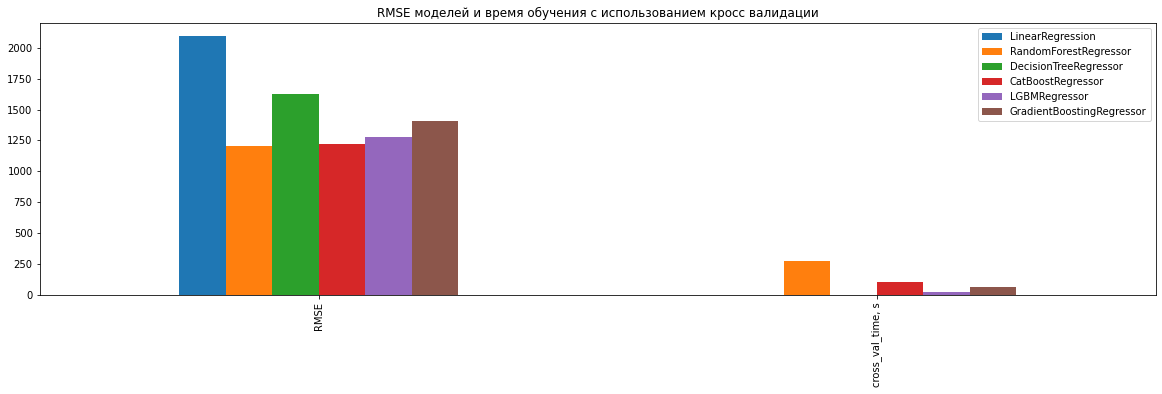

In [215]:
rmse_result.plot(kind='bar', title='RMSE моделей и время обучения с использованием кросс валидации', figsize=(20,5))

## Анализ моделей

In [216]:
result = pd.DataFrame(index=["RandomForestRegressor","DecisionTreeRegressor", "CatBoostRegressor",'GradientBoostingRegressor'],
                      columns=["RMSE", "learning_time", "predict_time"])

In [217]:
def best_hypers_for_model(model, hyperparams, scorer):

    clf = GridSearchCV(model, hyperparams, scoring=scorer)
    clf.fit(features_train, target_train)
    print(str(model)[:-2],"Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params']):
        print("%0.6f for %r"% (abs(mean), params))

In [218]:
def best_model_result(model_dict):
    
    for model_name in tqdm(model_dict):
        l_start = time.time()
        model = model_dict[model_name]
        model.fit(features_train, target_train)
        l_end = time.time()
        result.loc[model_name, "learning_time"] = l_end - l_start
        p_start = time.time()
        predictions = model.predict(features_test)
        p_end = time.time()
        result.loc[model_name, "predict_time"] = p_end - p_start
        result.loc[model_name, "RMSE"] = rmse(predictions, target_test)

In [219]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 21)],
                  'random_state':[12345]}
best_hypers_for_model(DecisionTreeRegressor(),MODEL_SETTINGS,rmse_scorer)

DecisionTreeRegressor Best parameters set found on development set:

{'max_depth': 13, 'random_state': 12345}

Grid scores on development set:

2261.490008 for {'max_depth': 2, 'random_state': 12345}
2068.664001 for {'max_depth': 3, 'random_state': 12345}
1883.910720 for {'max_depth': 4, 'random_state': 12345}
1756.871555 for {'max_depth': 5, 'random_state': 12345}
1670.899956 for {'max_depth': 6, 'random_state': 12345}
1605.851489 for {'max_depth': 7, 'random_state': 12345}
1552.878652 for {'max_depth': 8, 'random_state': 12345}
1506.640837 for {'max_depth': 9, 'random_state': 12345}
1465.442146 for {'max_depth': 10, 'random_state': 12345}
1443.212665 for {'max_depth': 11, 'random_state': 12345}
1426.792416 for {'max_depth': 12, 'random_state': 12345}
1423.007700 for {'max_depth': 13, 'random_state': 12345}
1430.847807 for {'max_depth': 14, 'random_state': 12345}
1442.764781 for {'max_depth': 15, 'random_state': 12345}
1469.476814 for {'max_depth': 16, 'random_state': 12345}
1493.4303

In [220]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 21)],
                  'n_estimators': [x for x in range (2,10)],
                  'random_state':[12345]}
best_hypers_for_model(RandomForestRegressor(),MODEL_SETTINGS,rmse_scorer)


RandomForestRegressor Best parameters set found on development set:

{'max_depth': 19, 'n_estimators': 9, 'random_state': 12345}

Grid scores on development set:

2237.735175 for {'max_depth': 2, 'n_estimators': 2, 'random_state': 12345}
2239.370129 for {'max_depth': 2, 'n_estimators': 3, 'random_state': 12345}
2238.514244 for {'max_depth': 2, 'n_estimators': 4, 'random_state': 12345}
2229.653022 for {'max_depth': 2, 'n_estimators': 5, 'random_state': 12345}
2230.658883 for {'max_depth': 2, 'n_estimators': 6, 'random_state': 12345}
2232.281708 for {'max_depth': 2, 'n_estimators': 7, 'random_state': 12345}
2234.135225 for {'max_depth': 2, 'n_estimators': 8, 'random_state': 12345}
2235.584358 for {'max_depth': 2, 'n_estimators': 9, 'random_state': 12345}
2045.247147 for {'max_depth': 3, 'n_estimators': 2, 'random_state': 12345}
2047.671024 for {'max_depth': 3, 'n_estimators': 3, 'random_state': 12345}
2047.065059 for {'max_depth': 3, 'n_estimators': 4, 'random_state': 12345}
2037.658639 

In [221]:
MODEL_SETTINGS = {
  'learning_rate': [0.1, 0.5, 0.8],
  'n_estimators': [x for x in range (2,10)],
  'max_depth': [x for x in range (2,20)]}
                
best_hypers_for_model(GradientBoostingRegressor(),MODEL_SETTINGS,rmse_scorer)

GradientBoostingRegressor Best parameters set found on development set:

{'learning_rate': 0.5, 'max_depth': 11, 'n_estimators': 9}

Grid scores on development set:

2951.679244 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 2}
2826.407905 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 3}
2713.732516 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 4}
2618.312798 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 5}
2533.033753 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 6}
2456.718579 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 7}
2387.441666 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 8}
2319.438276 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 9}
2903.999408 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 2}
2761.020209 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 3}
2629.110600 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 4}
2517.904124 for {'le

In [222]:
MODEL_SETTINGS = {
  'verbose':[False],
  'learning_rate': [0.1, 0.5, 0.8],
  'iterations': [2,3,5],
  'max_depth': [x for x in range (2,20)]}
best_hypers_for_model(CatBoostRegressor(),MODEL_SETTINGS,rmse_scorer)


<catboost.core.CatBoostRegressor object at 0x7f8b09351e8 Best parameters set found on development set:

{'iterations': 5, 'learning_rate': 0.8, 'max_depth': 16, 'verbose': False}

Grid scores on development set:

2954.133004 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 2, 'verbose': False}
2931.477694 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 3, 'verbose': False}
2902.735548 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 4, 'verbose': False}
2884.986579 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 5, 'verbose': False}
2872.516960 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 6, 'verbose': False}
2859.026786 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 7, 'verbose': False}
2845.802138 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 8, 'verbose': False}
2835.470602 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 9, 'verbose': False}
2827.555572 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth'

In [223]:
MODEL_SETTINGS = {
  'learning_rate': [0.1, 0.5, 0.8],
  'n_estimators': [x for x in range (2,10)],
    'random_state':[12345],
  'max_depth': [x for x in range (2,20)]}
best_hypers_for_model(LGBMRegressor(),MODEL_SETTINGS,rmse_scorer)

LGBMRegressor Best parameters set found on development set:

{'learning_rate': 0.8, 'max_depth': 9, 'n_estimators': 9, 'random_state': 12345}

Grid scores on development set:

2951.679244 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 2, 'random_state': 12345}
2826.407905 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 3, 'random_state': 12345}
2713.732516 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 4, 'random_state': 12345}
2618.312798 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 5, 'random_state': 12345}
2533.033752 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 6, 'random_state': 12345}
2456.718578 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 7, 'random_state': 12345}
2387.441665 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 8, 'random_state': 12345}
2319.438276 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 9, 'random_state': 12345}
2903.999410 for {'learning_rate': 0.1, 'max_dept

### Обучение лучших моделей

In [224]:
best_model_result({'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=13, random_state=12345),
                   'RandomForestRegressor': RandomForestRegressor(max_depth=19, n_estimators=9, random_state=12345),
                   'CatBoostRegressor': CatBoostRegressor(iterations=5, learning_rate=0.8, max_depth=16, verbose=False),
                    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.5, max_depth=11, n_estimators=9),
                  'LGBMRegressor': LGBMRegressor(learning_rate=0.8, max_depth=9, n_estimators=9, random_state=12345)})


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


### Вывод
* рейтинг моделей по скорости обучения:
    1. DecisionTreeRegressor
    2. LGBMRegressor
    3. RandomForestRegressor
    4. GradientBoostingRegressor
    5. CatBoostRegressor

* рейтинг моделей по скорости предсказания:
    1. CatBoostRegressor
    2. DecisionTreeRegressor
    3. LGBMRegressor
    4. GradientBoostingRegressor
    5. RandomForestRegressor
       
* рейтинг моделей по качеству:
    1. RandomForestRegressor 
    2. GradientBoostingRegressor
    3. CatBoostRegressor
    4. LGBMRegressor
    5. DecisionTreeRegressor
    

Итоговый средний балл:

    DecisionTreeRegressor - 2.666
    CatBoostRegressor - 3
    RandomForestRegressor - 3
    LGBMRegressor - 3
    GradientBoostingRegressor - 3.333
    
Чтобы рекомендовать заказчику какую-либо модель, необходимо определить, какие показатели для него наиболее важны. Сортировка по показателям представлена ниже

In [235]:
result

,RMSE,learning_time,predict_time
RandomForestRegressor,1239.846363,5.192082,0.158919
DecisionTreeRegressor,1401.511995,0.619559,0.013168
CatBoostRegressor,1332.704473,7.516913,0.007571
GradientBoostingRegressor,1261.267411,5.234272,0.044043
LGBMRegressor,1363.070496,4.268816,0.023631


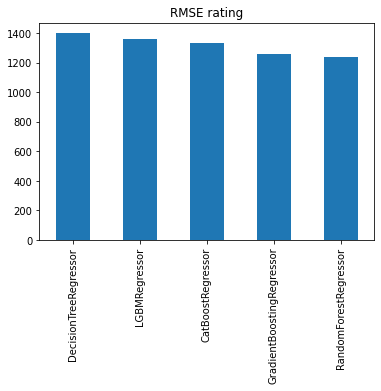

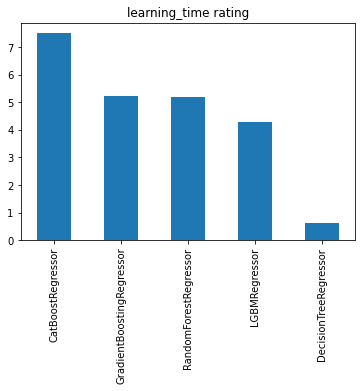

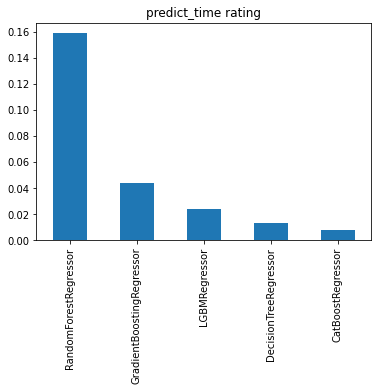

In [231]:
for column in result.columns:
    result[column].sort_values(ascending=False).plot(kind='bar', title=column+" rating")
    plt.show()
